In [3]:
import torch
import pandas as pd
import numpy as np

# Import dataset utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

In [4]:
dataframe = pd.read_csv('../data/final.csv', sep=';')
dataframe.head()

,sexo,Estado_civil,Status_empl,Licenca,Tipo_Resid,Residencia,Alcoolatra,Droga,Suic_familia,Dep_familia,...,Eixo I: Panico sem agorafobia,Eixo I: Fobia especifica,Eixo I: Fobia social,Eixo I: Obsessivo-compulsivo,Eixo I: Estresse pos-traumatico,Eixo I: Ansiedade generalizada,Eixo II: Personalidade paranoica,Eixo II: Transtorno de personalidade,TOC,idade
0,M,3.0,NaN,0.0,3.0,1.0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,40.0
1,F,1.0,3.0,0.0,4.0,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0
2,F,1.0,2.0,0.0,1.0,2.0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
3,F,1.0,3.0,0.0,1.0,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,30.0
4,F,4.0,2.0,0.0,1.0,NaN,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0


In [24]:
# selected = ['Suicidio', 'Trabalho e interesses', 'Apetite', 'Sentimentos_culpa', 'Perda de insights',
#             'Ansiedade somática', 'Ansiedade', 'Perda de peso', 'Lentidao pensamento e fala',
#             'Hipocondriase', 'Energia', 'Libido',  'sexo','Pontuação total', 'Deprimido']

selected = ['Suicidio', 'Trabalho e interesses', 'Apetite', 'Sentimentos_culpa', 'Perda de insights',
            'Ansiedade somática', 'Ansiedade', 'Perda de peso', 'Lentidao pensamento e fala',
            'Hipocondriase', 'Energia', 'Libido',  'sexo', 'Deprimido']

dataframe['sexo'].replace({'M': 0, 'F': 1}, inplace=True)
dataframe['sexo'].fillna(0, inplace=True) # Talvez jogar fora

# selected = dataframe._get_numeric_data().columns

df_suic = dataframe[selected]


df_suic.dropna(inplace=True)

df_suic = df_suic.astype(float)

# # Normalize each column
for col in df_suic.columns:
    df_suic[col] = (df_suic[col] - df_suic[col].mean()) / df_suic[col].std()

df_suic.dropna(inplace=True)
df_suic.shape

/var/folders/8c/4vjtx4c53532tgcgnczsgk580000gn/T/ipykernel_61064/2405209439.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suic.dropna(inplace=True)


(3944, 14)

In [6]:
class MyDataset(Dataset):
 
  def __init__(self, input_dataframe, split="train", target="Suicidio", ignore_columns=[], train_ratio=0.8):
    
    self.split = split
    self.target = target
    self.ignore_columns = ignore_columns

    for coll in self.ignore_columns:
       if coll in input_dataframe.columns:
        input_dataframe = input_dataframe.drop(coll, axis=1)

    self.classification_dim = len(input_dataframe[self.target].unique())
    self.data_dim = len(input_dataframe.columns) - 1
    self.embbeding_dim = input_dataframe.max().max() + 1

    y = input_dataframe[target].values
    x = input_dataframe.drop(target, axis = 1).values

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=42)

  def __len__(self):
    if self.split == "train":
      return len(self.x_train)
    elif self.split == "test":
      return len(self.x_test)
    else:
      raise ValueError("Split must be train or test")

  def __getitem__(self,idx):
    target = torch.zeros(self.classification_dim)

    if self.split == "train":
      # target[self.y_train[idx]] = 1
      target = torch.tensor(self.y_train[idx], dtype=torch.float)
      return (torch.tensor(self.x_train[idx], dtype=torch.float), target)
    elif self.split == "test":
      # target[self.y_test[idx]] = 1
      target = torch.tensor(self.y_test[idx], dtype=torch.float)
      return (torch.tensor(self.x_test[idx], dtype=torch.float), target)
    else:
      raise ValueError("Split must be train or test")


In [7]:
train_dataset = MyDataset(df_suic, split="train", target="Suicidio", ignore_columns=[], train_ratio=0.8)
test_dataset = MyDataset(df_suic, split="test", target="Suicidio", ignore_columns=[], train_ratio=0.8)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [43]:
## Define a MLP model with N layers

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_layers=2):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
    
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_dim, self.hidden_dim))
        for i in range(self.n_layers - 1):
            self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.append(nn.Dropout(0.2))
            self.layers.append(nn.BatchNorm1d(self.hidden_dim))
            # self.layers.append(nn.ReLU())
            self.layers.append(nn.LeakyReLU())

        self.layers.append(nn.Linear(self.hidden_dim, self.output_dim))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define a Model with a embbeding layer and a MLP

class ClassificationModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_layers=2):
        super(ClassificationModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # self.embbeding_layer = nn.Embedding(self.embbeding_dim, self.embbeding_out)
        self.mlp = MLP(self.input_dim, self.output_dim, self.hidden_dim, self.n_layers)

    def forward(self, x):
        # x = self.embbeding_layer(x)
        # x = x.view(x.shape[0], -1)
        x = self.mlp(x)
        
        ## classification
        # x = F.softmax(x, dim=1)
        ## regression
        x = torch.sigmoid(x)

        return x

# test the model
example_batch = next(iter(train_loader))
example_data, example_targets = example_batch

model = ClassificationModel(train_dataset.data_dim, 1, hidden_dim=128, n_layers=4)
print(model)
print("Input", example_data[:5, :5])

# ## Check if input has inf or nan
# print(torch.isnan(example_data).any())
# print(torch.isinf(example_data).any())

print("Batch shape:", example_data.shape)
res = model(example_data)
print("Output shape:", res.shape)

print("Output:", res[:5])

ClassificationModel(
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=14, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Linear(in_features=128, out_features=128, bias=True)
      (6): Dropout(p=0.2, inplace=False)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Linear(in_features=128, out_features=128, bias=True)
      (10): Dropout(p=0.2, inplace=False)
      (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.01)
      (13): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)
Input tensor([[-0.6140, -0.9086, -0.0524, -0.3038, -1.9163],
        [ 0.5896,  0

In [44]:
## Make Lightning Module
from pytorch_lightning import LightningModule

class BaseModel(LightningModule):
    """A LightningModule organizes your PyTorch code into 6 sections:
        - Computations (init)
        - Validation loop (validation_step)
        - Train loop (training_step)
        - Test loop (test_step)
        - Prediction Loop (predict_step)
        - Optimizers and LR Schedulers (configure_optimizers)
    """

    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, lr=1e-5):
        super().__init__()
        self.model = ClassificationModel(input_dim, output_dim, hidden_dim=hidden_dim, n_layers=n_layers)
        self.lr = lr

        # save hyperparameters
        self.save_hyperparameters()

    def step(self, batch):
        x, y = batch
        y_hat = self.model(x).squeeze()
        # loss = F.binary_cross_entropy(y_hat, y)
        # L1 Loss
        loss = F.l1_loss(y_hat, y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch)
        self.log('overfit/train_loss', loss, )
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch)
        self.log('overfit/val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [45]:
# Import trainer
from pytorch_lightning.trainer import Trainer

# Import callbacks
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Initialize callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='overfit/train_loss',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='overfit/train_loss',
    min_delta=0.05,
    patience=100,
    verbose=False,
    mode='min'
)

callbacks = [checkpoint_callback, early_stopping]
# callbacks = []

# Initialize model
model = BaseModel(input_dim=train_dataset.data_dim, output_dim=1, hidden_dim=128, n_layers=16)
print(model)

# Initialize a trainer
trainer = Trainer(accelerator='gpu', devices=1, check_val_every_n_epoch=10, log_every_n_steps=10, callbacks=callbacks, auto_lr_find=True, enable_progress_bar=False)

BaseModel(
  (model): ClassificationModel(
    (mlp): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=14, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Dropout(p=0.2, inplace=False)
        (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.01)
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Dropout(p=0.2, inplace=False)
        (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): LeakyReLU(negative_slope=0.01)
        (9): Linear(in_features=128, out_features=128, bias=True)
        (10): Dropout(p=0.2, inplace=False)
        (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): LeakyReLU(negative_slope=0.01)
        (13): Linear(in_features=128, out_features=128, bias=True)
        (14): Dropout(p=0.2, inplace=

Traceback (most recent call last):
  File "/Users/cadar/miniconda3/envs/causal/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
  File "/var/folders/8c/4vjtx4c53532tgcgnczsgk580000gn/T/ipykernel_15413/1090833827.py", line 32, in <module>
    trainer = Trainer(accelerator='gpu', devices=1, check_val_every_n_epoch=10, log_every_n_steps=10, callbacks=callbacks, auto_lr_find=True, enable_progress_bar=False)
  File "/Users/cadar/miniconda3/envs/causal/lib/python3.9/site-packages/pytorch_lightning/utilities/argparse.py", line 345, in insert_env_defaults
  File "/Users/cadar/miniconda3/envs/causal/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 534, in __init__
  File "/Users/cadar/miniconda3/envs/causal/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 619, in _setup_on_init
  File "/Users/cadar/miniconda3/envs/causal/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1740, in _log_device_

In [ ]:
# trainer.tune(model, train_loader)

In [37]:
# Train the model ⚡
trainer.fit(model, train_loader, test_loader)


  | Name  | Type                | Params
----------------------------------------------
0 | model | ClassificationModel | 253 K 
----------------------------------------------
253 K     Trainable params
0         Non-trainable params
253 K     Total params
1.014     Total estimated model params size (MB)


In [66]:
import causalnex.structure.notears as notears
import causalnex.plots as plots

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

TypeError: 'AxesSubplot' object is not subscriptable

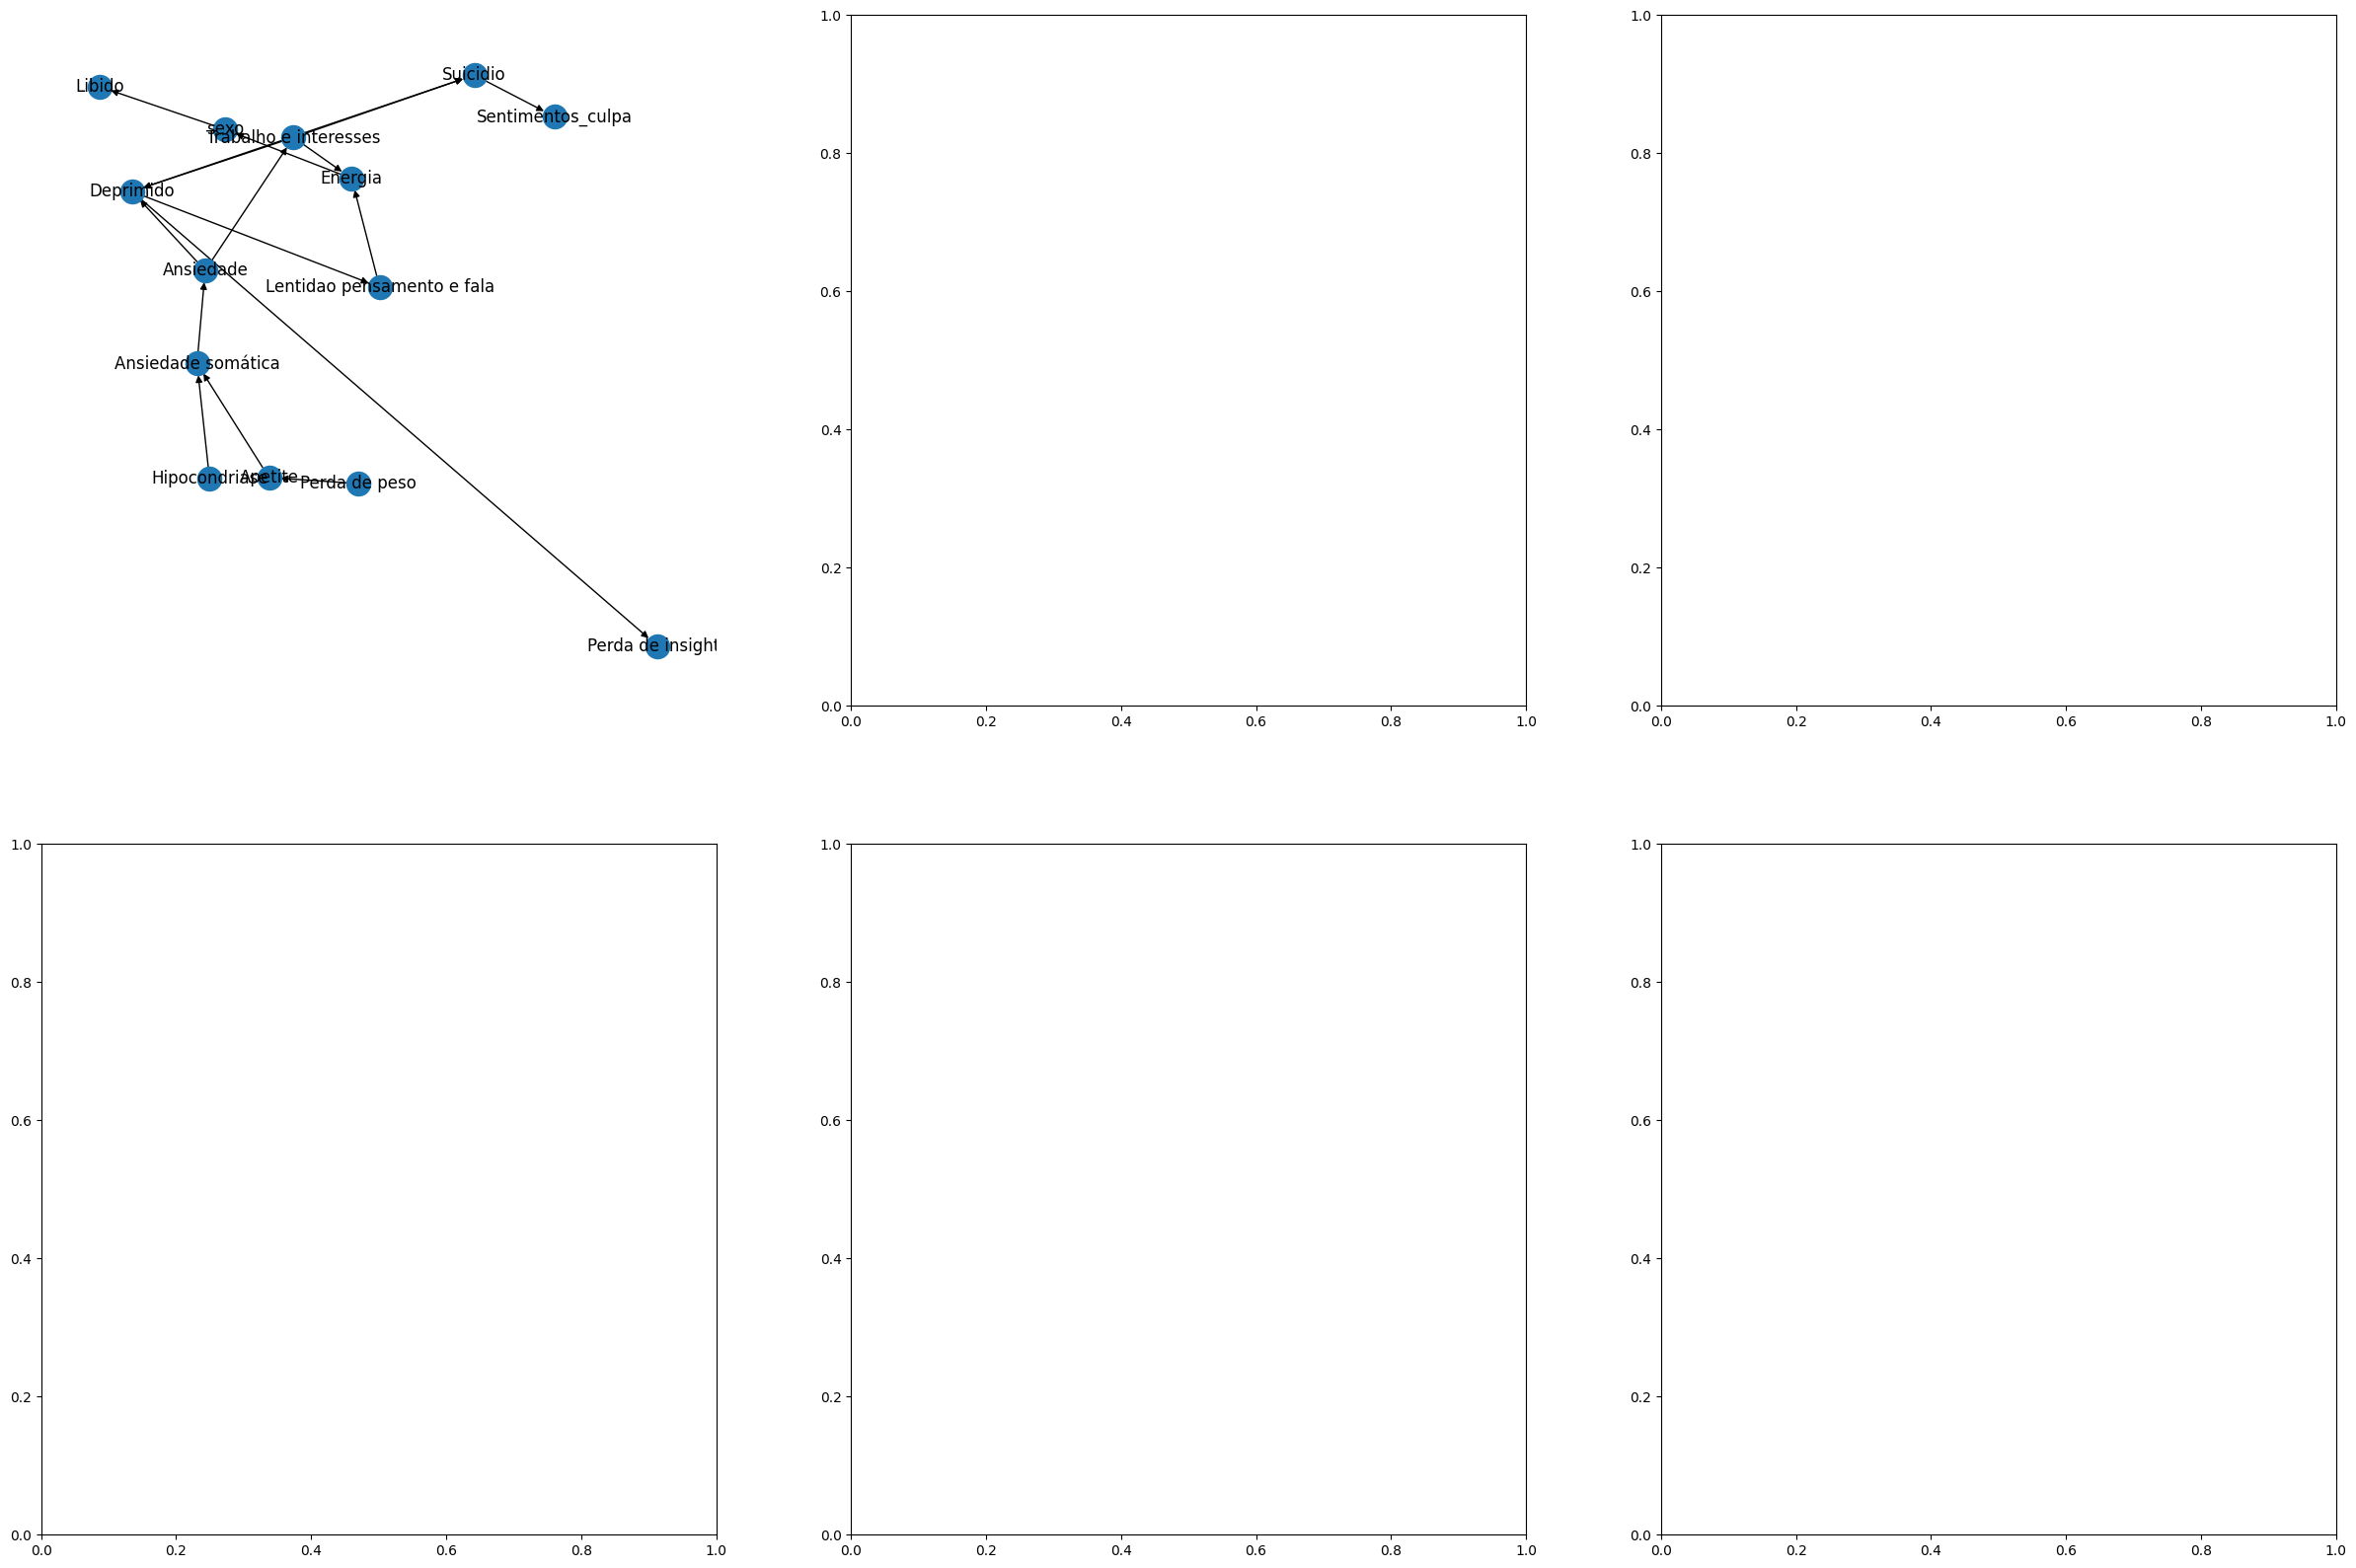

In [87]:
sm = notears.from_pandas(df_suic, max_iter=10000)


ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
for i, ax in enumerate(axs.flatten()):
    if i > len(ths) - 1:
        # Clean up empty axes
        fig.delaxes(ax)
        continue

    th = ths[i]
    sm.remove_edges_below_threshold(th)

    # Draw only nodes with edges
    sm2 = sm.edge_subgraph(sm.edges)
    nx.draw(sm, ax=ax, with_labels=True, nodelist=sm2.nodes)

    # Add rec around ax to make it easier to see
    axis = ax.axis()
    rec = plt.Rectangle((axis[0] - 0.7, axis[2] - 0.2), (axis[1] - axis[0]) + 1, (axis[3] - axis[2]) + 0.4, fill=False, lw=2, linestyle="dotted")
    ax.add_patch(rec)
    ax.set_title(f"Threshold: {th}")
    # ax.set_box_aspect(1)



fig.show()